# Missing Values
Missing values happen. Be prepared for this common challenge in real datasets.

## Introduction
There are many ways data can end up with missing values. For example,

- A 2 bedroom house won't include a value for the size of a third bedroom.
- A survey respondent may choose not to share his income.
  
Most machine learning libraries (including scikit-learn) give an error if you try to build a model using data with missing values. So you'll need to choose one of the strategies below.

### Three Approaches
1) **A Simple Option: Drop Columns with Missing Values**
   
Unless most values in the dropped columns are missing, the model loses access to a lot of (potentially useful!) information with this approach. As an extreme example, consider a dataset with 10,000 rows, where one important column is missing a single entry. This approach would drop the column entirely!

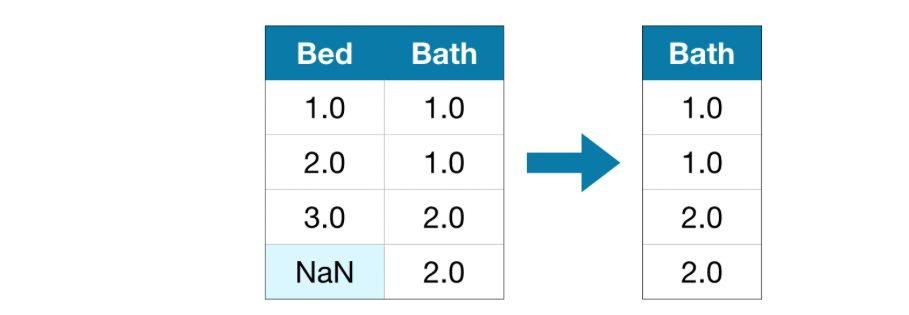

In [20]:
Image(('/Users/tusharrao/Downloads/Sim.png'))

2) **A Better Option: Imputation**

**Imputation** fills in the missing values with some number. For instance, we can fill in the mean value along each column.

The imputed value won't be exactly right in most cases, but it usually leads to more accurate models than you would get from dropping the column entirely.


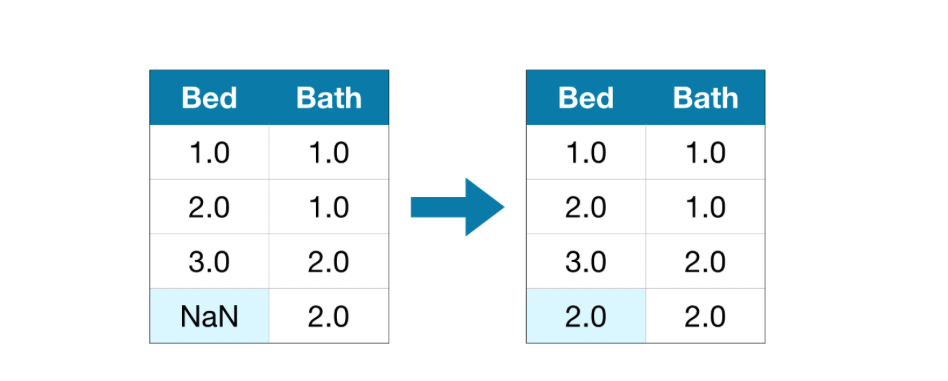

In [21]:
Image('/Users/tusharrao/Downloads/Imp.png')

3) **An Extension To Imputation**

Imputation is the standard approach, and it usually works well. However, imputed values may be systematically above or below their actual values (which weren't collected in the dataset). Or rows with missing values may be unique in some other way. In that case, your model would make better predictions by considering which values were originally missing.

In this approach, we impute the missing values. And, additionally, for each column with missing entries in the original dataset, we add a new column that shows the location of the imputed entries.

In some cases, this will meaningfully improve results. In other cases, it doesn't help at all.

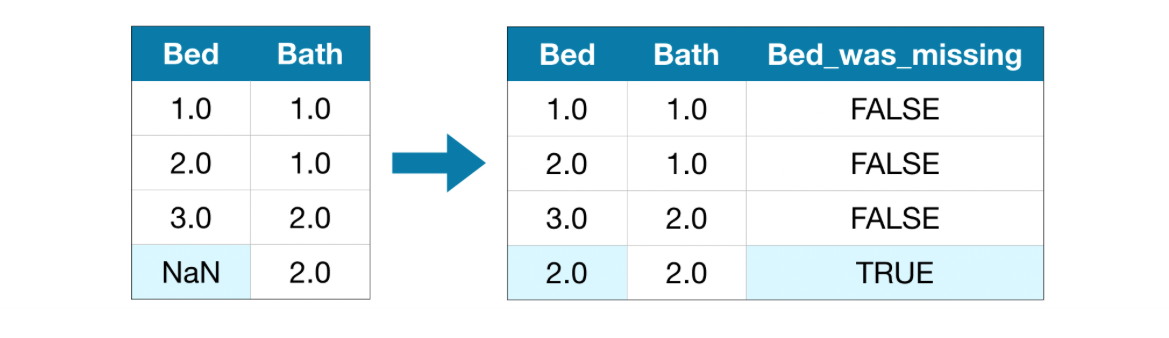

In [22]:
Image('/Users/tusharrao/Downloads/Bett.png')

### Example
In the example, we will work with the Melbourne Housing dataset. 

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import Image

# Load the data
data = pd.read_csv('/Users/tusharrao/Downloads/melb_data.csv')

# Select target
y = data.Price

# To keep things simple, we'll use only numerical predictors
melb_predictors = data.drop(['Price'], axis=1)
X = melb_predictors.select_dtypes(exclude=['object'])

# Divide data into training and validation subsets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=0)

### Define Function to Measure Quality of Each Approach

We define a function score_dataset() to compare different approaches to dealing with missing values. This function reports the mean absolute error (MAE) from a random forest model.

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=10, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Score from Approach 1 (Drop Columns with Missing Values)

Since we are working with both training and validation sets, we are careful to drop the same columns in both DataFrames.

In [3]:
# Get names of columns with missing values
cols_with_missing = [col for col in X_train.columns
                     if X_train[col].isnull().any()]

# Drop columns in training and validation data
reduced_X_train = X_train.drop(cols_with_missing, axis=1)
reduced_X_valid = X_valid.drop(cols_with_missing, axis=1)

print("MAE from Approach 1 (Drop columns with missing values):")
print(score_dataset(reduced_X_train, reduced_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop columns with missing values):
183550.22137772635


### Score from Approach 2 (Imputation)

Next, we use SimpleImputer to replace missing values with the mean value along each column.

Although it's simple, filling in the mean value generally performs quite well (but this varies by dataset). While statisticians have experimented with more complex ways to determine imputed values (such as regression imputation, for instance), the complex strategies typically give no additional benefit once you plug the results into sophisticated machine learning models.

In [5]:
from sklearn.impute import SimpleImputer

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = X_train.columns
imputed_X_valid.columns = X_valid.columns

print("MAE from Approach 2 (Imputation):")
print(score_dataset(imputed_X_train, imputed_X_valid, y_train, y_valid))

MAE from Approach 2 (Imputation):
178166.46269899711


We see that Approach 2 has lower MAE than Approach 1, so Approach 2 performed better on this dataset.

### Score from Approach 3 (An Extension to Imputation)

Next, we impute the missing values, while also keeping track of which values were imputed.

In [6]:
# Make copy to avoid changing original data (when imputing)
X_train_plus = X_train.copy()
X_valid_plus = X_valid.copy()

# Make new columns indicating what will be imputed
for col in cols_with_missing:
    X_train_plus[col + '_was_missing'] = X_train_plus[col].isnull()
    X_valid_plus[col + '_was_missing'] = X_valid_plus[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train_plus = pd.DataFrame(my_imputer.fit_transform(X_train_plus))
imputed_X_valid_plus = pd.DataFrame(my_imputer.transform(X_valid_plus))

# Imputation removed column names; put them back
imputed_X_train_plus.columns = X_train_plus.columns
imputed_X_valid_plus.columns = X_valid_plus.columns

print("MAE from Approach 3 (An Extension to Imputation):")
print(score_dataset(imputed_X_train_plus, imputed_X_valid_plus, y_train, y_valid))

MAE from Approach 3 (An Extension to Imputation):
178927.503183954


As we can see, Approach 3 performed slightly worse than Approach 2.

**So, why did imputation perform better than dropping the columns?**

The training data has 10864 rows and 12 columns, where three columns contain missing data. For each column, less than half of the entries are missing. Thus, dropping the columns removes a lot of useful information, and so it makes sense that imputation would perform better.

In [7]:
# Shape of training data (num_rows, num_columns)
print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

(10864, 12)
Car               49
BuildingArea    5156
YearBuilt       4307
dtype: int64


## Conclusion
As is common, imputing missing values (in Approach 2 and Approach 3) yielded better results, relative to when we simply dropped columns with missing values (in Approach 1).

# Categorical Variables
There's a lot of non-numeric data out there. Here's how to use it for machine learning.

## Introduction
A categorical variable takes only a limited number of values.

- Consider a survey that asks how often you eat breakfast and provides four options: "Never", "Rarely", "Most days", or "Every day". In this case, the data is categorical, because responses fall into a fixed set of categories.
- If people responded to a survey about which what brand of car they owned, the responses would fall into categories like "Honda", "Toyota", and "Ford". In this case, the data is also categorical.
  
You will get an error if you try to plug these variables into most machine learning models in Python without preprocessing them first. In this tutorial, we'll compare three approaches that you can use to prepare your categorical data.

## Three Approaches
1) **Drop Categorical Variables**

The easiest approach to dealing with categorical variables is to simply remove them from the dataset. This approach will only work well if the columns did not contain useful information.

2) **Ordinal Encoding**

Ordinal encoding assigns each unique value to a different integer. 

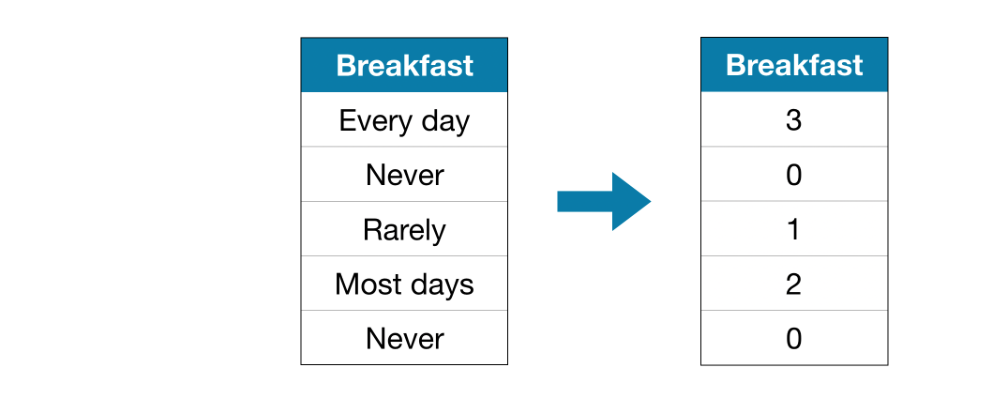

In [26]:
Image('/Users/tusharrao/Downloads/Ord.png')

This approach assumes an ordering of the categories: "Never" (0) < "Rarely" (1) < "Most days" (2) < "Every day" (3).

This assumption makes sense in this example, because there is an indisputable ranking to the categories. Not all categorical variables have a clear ordering in the values, but we refer to those that do as ordinal variables. For tree-based models (like decision trees and random forests), you can expect ordinal encoding to work well with ordinal variables.

3) **One-Hot Encoding**

One-hot encoding creates new columns indicating the presence (or absence) of each possible value in the original data. To understand this, we'll work through an example.

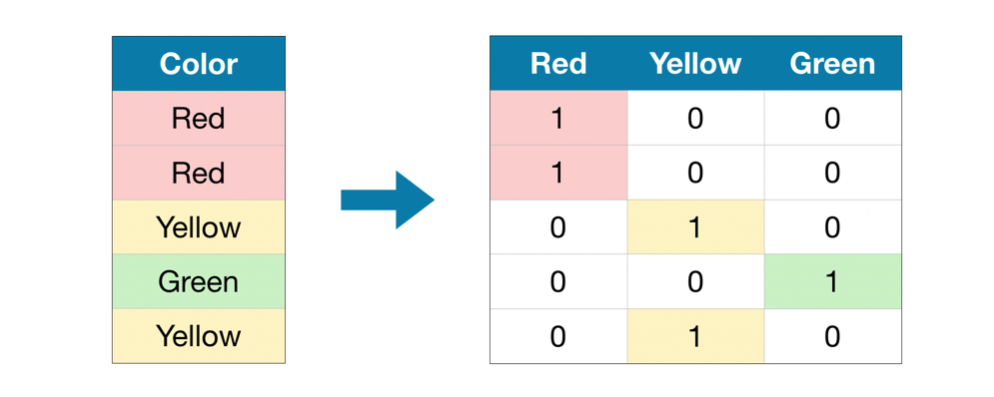

In [28]:
Image('/Users/tusharrao/Downloads/One.png')

In the original dataset, "Color" is a categorical variable with three categories: "Red", "Yellow", and "Green". The corresponding one-hot encoding contains one column for each possible value, and one row for each row in the original dataset. Wherever the original value was "Red", we put a 1 in the "Red" column; if the original value was "Yellow", we put a 1 in the "Yellow" column, and so on.

In contrast to ordinal encoding, one-hot encoding does not assume an ordering of the categories. Thus, you can expect this approach to work particularly well if there is no clear ordering in the categorical data (e.g., "Red" is neither more nor less than "Yellow"). We refer to categorical variables without an intrinsic ranking as nominal variables.

One-hot encoding generally does not perform well if the categorical variable takes on a large number of values (i.e., you generally won't use it for variables taking more than 15 different values).

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('/Users/tusharrao/Downloads/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Drop columns with missing values (simplest approach)
cols_with_missing = [col for col in X_train_full.columns if X_train_full[col].isnull().any()] 
X_train_full.drop(cols_with_missing, axis=1, inplace=True)
X_valid_full.drop(cols_with_missing, axis=1, inplace=True)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

We take a peek at the training data with the head() method below.

In [9]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Landsize,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,0.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,193.0,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,555.0,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,265.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,673.0,-37.76230,144.8272,4217.0


Next, we obtain a list of all of the categorical variables in the training data.

We do this by checking the data type (or dtype) of each column. The object dtype indicates a column has text (there are other things it could theoretically be, but that's unimportant for our purposes). For this dataset, the columns with text indicate categorical variables.

In [10]:
# Get list of categorical variables
s = (X_train.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Type', 'Method', 'Regionname']


## Define Function to Measure Quality of Each Approach

We define a function score_dataset() to compare the three different approaches to dealing with categorical variables. This function reports the mean absolute error (MAE) from a random forest model. In general, we want the MAE to be as low as possible!

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Function for comparing different approaches
def score_dataset(X_train, X_valid, y_train, y_valid):
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, y_train)
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

### Score from Approach 1 (Drop Categorical Variables)

We drop the object columns with the select_dtypes() method.

In [12]:
drop_X_train = X_train.select_dtypes(exclude=['object'])
drop_X_valid = X_valid.select_dtypes(exclude=['object'])

print("MAE from Approach 1 (Drop categorical variables):")
print(score_dataset(drop_X_train, drop_X_valid, y_train, y_valid))

MAE from Approach 1 (Drop categorical variables):
175707.61156991488


### Score from Approach 2 (Ordinal Encoding)

Scikit-learn has a OrdinalEncoder class that can be used to get ordinal encodings. We loop over the categorical variables and apply the ordinal encoder separately to each column.

In [13]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = X_train.copy()
label_X_valid = X_valid.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder()
label_X_train[object_cols] = ordinal_encoder.fit_transform(X_train[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(X_valid[object_cols])

print("MAE from Approach 2 (Ordinal Encoding):") 
print(score_dataset(label_X_train, label_X_valid, y_train, y_valid))

MAE from Approach 2 (Ordinal Encoding):
165919.14549617787


In the code cell above, for each column, we randomly assign each unique value to a different integer. This is a common approach that is simpler than providing custom labels; however, we can expect an additional boost in performance if we provide better-informed labels for all ordinal variables.

### Score from Approach 3 (One-Hot Encoding)

We use the OneHotEncoder class from scikit-learn to get one-hot encodings. There are a number of parameters that can be used to customize its behavior.

- We set handle_unknown='ignore' to avoid errors when the validation data contains classes that aren't represented in the training data, and
- setting sparse=False ensures that the encoded columns are returned as a numpy array (instead of a sparse matrix).
  
To use the encoder, we supply only the categorical columns that we want to be one-hot encoded. For instance, to encode the training data, we supply X_train[object_cols]. (object_cols in the code cell below is a list of the column names with categorical data, and so X_train[object_cols] contains all of the categorical data in the training set.)

In [15]:
from sklearn.preprocessing import OneHotEncoder

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_valid = X_valid.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)

# Ensure all columns have string type
OH_X_train.columns = OH_X_train.columns.astype(str)
OH_X_valid.columns = OH_X_valid.columns.astype(str)

print("MAE from Approach 3 (One-Hot Encoding):") 
print(score_dataset(OH_X_train, OH_X_valid, y_train, y_valid))

MAE from Approach 3 (One-Hot Encoding):
166111.84115541063


## Which approach is best?
In this case, dropping the categorical columns (Approach 1) performed worst, since it had the highest MAE score. As for the other two approaches, since the returned MAE scores are so close in value, there doesn't appear to be any meaningful benefit to one over the other.

In general, one-hot encoding (Approach 3) will typically perform best, and dropping the categorical columns (Approach 1) typically performs worst, but it varies on a case-by-case basis.

# Pipelines
A critical skill for deploying (and even testing) complex models with pre-processing.

## Introduction
Pipelines are a simple way to keep your data preprocessing and modeling code organized. Specifically, a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step.

Many data scientists hack together models without pipelines, but pipelines have some important benefits. Those include:

- **Cleaner Code**: Accounting for data at each step of preprocessing can get messy. With a pipeline, you won't need to manually keep track of your training and validation data at each step.
- **Fewer Bugs**: There are fewer opportunities to misapply a step or forget a preprocessing step.
- **Easier to Productionize**: It can be surprisingly hard to transition a model from a prototype to something deployable at scale. We won't go into the many related concerns here, but pipelines can help.
- **More Options for Model Validation**: You will see an example in the next tutorial, which covers cross-validation.

### Example

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('/Users/tusharrao/Downloads/melb_data.csv')

# Separate target from predictors
y = data.Price
X = data.drop(['Price'], axis=1)

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

We take a peek at the training data with the head() method below. Notice that the data contains both categorical data and columns with missing values. With a pipeline, it's easy to deal with both!

In [17]:
X_train.head()

,Type,Method,Regionname,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
12167,u,S,Southern Metropolitan,1,5.0,3182.0,1.0,1.0,1.0,0.0,NaN,1940.0,-37.85984,144.9867,13240.0
6524,h,SA,Western Metropolitan,2,8.0,3016.0,2.0,2.0,1.0,193.0,NaN,NaN,-37.85800,144.9005,6380.0
8413,h,S,Western Metropolitan,3,12.6,3020.0,3.0,1.0,1.0,555.0,NaN,NaN,-37.79880,144.8220,3755.0
2919,u,SP,Northern Metropolitan,3,13.0,3046.0,3.0,1.0,1.0,265.0,NaN,1995.0,-37.70830,144.9158,8870.0
6043,h,S,Western Metropolitan,3,13.3,3020.0,3.0,1.0,2.0,673.0,673.0,1970.0,-37.76230,144.8272,4217.0


We construct the full pipeline in three steps.

### Step 1: Define Preprocessing Steps

Similar to how a pipeline bundles together preprocessing and modeling steps, we use the ColumnTransformer class to bundle together different preprocessing steps. The code below:

- imputes missing values in **numerical** data, and
- imputes missing values and applies a one-hot encoding to **categorical** data.

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### Step 2: Define the Model

Next, we define a random forest model with the familiar RandomForestRegressor class.

In [19]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, random_state=0)

### Step 3: Create and Evaluate the Pipeline

Finally, we use the Pipeline class to define a pipeline that bundles the preprocessing and modeling steps. There are a few important things to notice:

- With the pipeline, we preprocess the training data and fit the model in a single line of code. (In contrast, without a pipeline, we have to do imputation, one-hot encoding, and model training in separate steps. This becomes especially messy if we have to deal with both numerical and categorical variables!)
- With the pipeline, we supply the unprocessed features in X_valid to the predict() command, and the pipeline automatically preprocesses the features before generating predictions. (However, without a pipeline, we have to remember to preprocess the validation data before making predictions.)

In [20]:
from sklearn.metrics import mean_absolute_error

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('MAE:', score)

MAE: 160623.3888096991


## Conclusion
Pipelines are valuable for cleaning up machine learning code and avoiding errors, and are especially useful for workflows with sophisticated data preprocessing.

# Cross-Validation
A better way to test your models.

In this notebook, we will learn how to use cross-validation for better measures of model performance.

## Introduction
Machine learning is an iterative process.

You will face choices about what predictive variables to use, what types of models to use, what arguments to supply to those models, etc. So far, we have made these choices in a data-driven way by measuring model quality with a validation (or holdout) set.

But there are some drawbacks to this approach. To see this, imagine you have a dataset with 5000 rows. You will typically keep about 20% of the data as a validation dataset, or 1000 rows. But this leaves some random chance in determining model scores. That is, a model might do well on one set of 1000 rows, even if it would be inaccurate on a different 1000 rows.

At an extreme, you could imagine having only 1 row of data in the validation set. If you compare alternative models, which one makes the best predictions on a single data point will be mostly a matter of luck!

In general, the larger the validation set, the less randomness (aka "noise") there is in our measure of model quality, and the more reliable it will be. Unfortunately, we can only get a large validation set by removing rows from our training data, and smaller training datasets mean worse models!

### What is cross-validation?
In cross-validation, we run our modeling process on different subsets of the data to get multiple measures of model quality.

For example, we could begin by dividing the data into 5 pieces, each 20% of the full dataset. In this case, we say that we have broken the data into 5 "folds".

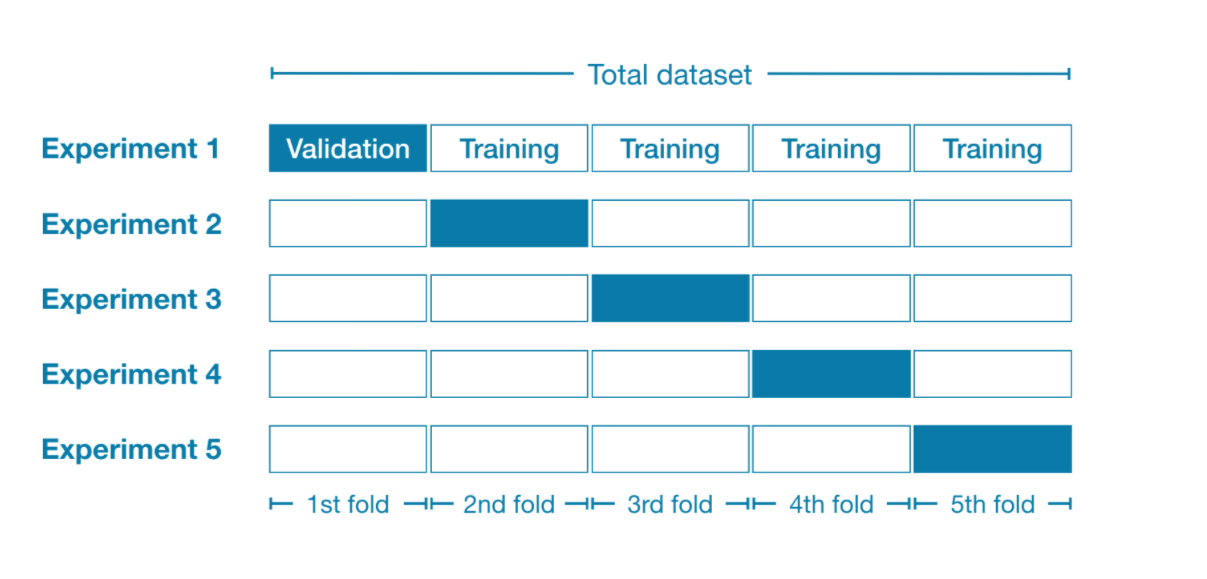

In [6]:
Image("/Users/tusharrao/Downloads/Cross.png")

Then, we run one experiment for each fold:

- In **Experiment 1**, we use the first fold as a validation (or holdout) set and everything else as training data. This gives us a measure of model quality based on a 20% holdout set.
- In **Experiment 2**, we hold out data from the second fold (and use everything except the second fold for training the model). The holdout set is then used to get a second estimate of model quality.
- We repeat this process, using every fold once as the holdout set. Putting this together, 100% of the data is used as holdout at some point, and we end up with a measure of model quality that is based on all of the rows in the dataset (even if we don't use all rows simultaneously).

### When should you use cross-validation?
Cross-validation gives a more accurate measure of model quality, which is especially important if you are making a lot of modeling decisions. However, it can take longer to run, because it estimates multiple models (one for each fold).

So, given these tradeoffs, when should you use each approach?

- For small datasets, where extra computational burden isn't a big deal, you should run cross-validation.
- For larger datasets, a single validation set is sufficient. Your code will run faster, and you may have enough data that there's little need to re-use some of it for holdout.
  
There's no simple threshold for what constitutes a large vs. small dataset. But if your model takes a couple minutes or less to run, it's probably worth switching to cross-validation.

Alternatively, you can run cross-validation and see if the scores for each experiment seem close. If each experiment yields the same results, a single validation set is probably sufficient.

In [7]:
import pandas as pd

# Read the data
data = pd.read_csv('/Users/tusharrao/Downloads/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

Then, we define a pipeline that uses an imputer to fill in missing values and a random forest model to make predictions.

While it's possible to do cross-validation without pipelines, it is quite difficult! Using a pipeline will make the code remarkably straightforward.

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=50,
                                                              random_state=0))
                             ])

We obtain the cross-validation scores with the cross_val_score() function from scikit-learn. We set the number of folds with the cv parameter.

In [9]:
from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_absolute_error')

print("MAE scores:\n", scores)

MAE scores:
 [301615.03450966 303143.49091344 287316.47967778 236087.57655869
 260385.2736474 ]


The scoring parameter chooses a measure of model quality to report: in this case, we chose negative mean absolute error (MAE). The docs for scikit-learn show a list of options.

It is a little surprising that we specify negative MAE. Scikit-learn has a convention where all metrics are defined so a high number is better. Using negatives here allows them to be consistent with that convention, though negative MAE is almost unheard of elsewhere.

We typically want a single measure of model quality to compare alternative models. So we take the average across experiments.

In [10]:
print("Average MAE score (across experiments):")
print(scores.mean())

Average MAE score (across experiments):
277709.5710613945


## Conclusion
Using cross-validation yields a much better measure of model quality, with the added benefit of cleaning up our code: note that we no longer need to keep track of separate training and validation sets. So, especially for small datasets, it's a good improvement!

# XGBoost
The most accurate modeling technique for structured data.

In this notebook, we will learn how to build and optimize models with gradient boosting. This method dominates many Kaggle competitions and achieves state-of-the-art results on a variety of datasets.

## Introduction
For much of this notebook, we have made predictions with the random forest method, which achieves better performance than a single decision tree simply by averaging the predictions of many decision trees.

We refer to the random forest method as an "ensemble method". By definition, **ensemble methods** combine the predictions of several models (e.g., several trees, in the case of random forests).

Next, we'll learn about another ensemble method called gradient boosting.

## Gradient Boosting
**Gradient boosting** is a method that goes through cycles to iteratively add models into an ensemble.

It begins by initializing the ensemble with a single model, whose predictions can be pretty naive. (Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.)

Then, we start the cycle:

- First, we use the current ensemble to generate predictions for each observation in the dataset. To make a prediction, we add the predictions from all models in the ensemble.
- These predictions are used to calculate a loss function (like mean squared error, for instance).
- Then, we use the loss function to fit a new model that will be added to the ensemble. Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss. (Side note: The "gradient" in "gradient boosting" refers to the fact that we'll use gradient descent on the loss function to determine the parameters in this new model.)
- Finally, we add the new model to ensemble, and ...
- ... repeat!

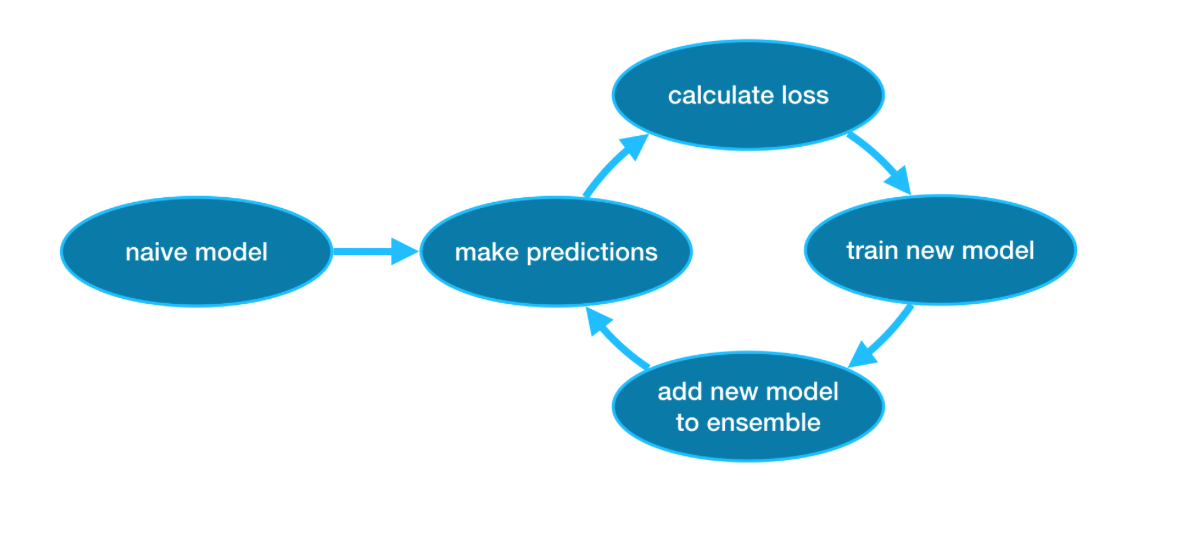

In [11]:
Image("/Users/tusharrao/Downloads/XG.png")

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
data = pd.read_csv('/Users/tusharrao/Downloads/melb_data.csv')

# Select subset of predictors
cols_to_use = ['Rooms', 'Distance', 'Landsize', 'BuildingArea', 'YearBuilt']
X = data[cols_to_use]

# Select target
y = data.Price

# Separate data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

In this example, we'll work with the **XGBoost** library. XGBoost stands for extreme **gradient boosting**, which is an implementation of gradient boosting with several additional features focused on performance and speed. (Scikit-learn has another version of gradient boosting, but XGBoost has some technical advantages.)

In the next code cell, we import the scikit-learn API for XGBoost (xgboost.XGBRegressor). This allows us to build and fit a model just as we would in scikit-learn. As you'll see in the output, the XGBRegressor class has many tunable parameters -- you'll learn about those soon!

from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(X_train, y_train)

In [2]:
from xgboost import XGBRegressor

my_model = XGBRegressor()
my_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


We also make predictions and evaluate the model.

In [3]:
from sklearn.metrics import mean_absolute_error

predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 234020.41802743005


## Parameter Tuning
XGBoost has a few parameters that can dramatically affect accuracy and training speed. The first parameters you should understand are:

n_estimators

n_estimators specifies how many times to go through the modeling cycle described above. It is equal to the number of models that we include in the ensemble.

- Too low a value causes underfitting, which leads to inaccurate predictions on both training data and test data.
- Too high a value causes overfitting, which causes accurate predictions on training data, but inaccurate predictions on test data (which is what we care about).
  
Typical values range from 100-1000, though this depends a lot on the learning_rate parameter discussed below.

Here is the code to set the number of models in the ensemble:

In [4]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


early_stopping_rounds

early_stopping_rounds offers a way to automatically find the ideal value for n_estimators. Early stopping causes the model to stop iterating when the validation score stops improving, even if we aren't at the hard stop for n_estimators. It's smart to set a high value for n_estimators and then use early_stopping_rounds to find the optimal time to stop iterating.

Since random chance sometimes causes a single round where validation scores don't improve, you need to specify a number for how many rounds of straight deterioration to allow before stopping. Setting early_stopping_rounds=5 is a reasonable choice. In this case, we stop after 5 straight rounds of deteriorating validation scores.

When using early_stopping_rounds, you also need to set aside some data for calculating the validation scores - this is done by setting the eval_set parameter.

We can modify the example above to include early stopping:

In [5]:
my_model = XGBRegressor(n_estimators=500)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)],
             verbose=False)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


If you later want to fit a model with all of your data, set n_estimators to whatever value you found to be optimal when run with early stopping.

learning_rate

Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the **learning rate**) before adding them in.

This means each tree we add to the ensemble helps us less. So, we can set a higher value for n_estimators without overfitting. If we use early stopping, the appropriate number of trees will be determined automatically.

In general, a small learning rate and large number of estimators will yield more accurate XGBoost models, though it will also take the model longer to train since it does more iterations through the cycle. As default, XGBoost sets learning_rate=0.1.

Modifying the example above to change the learning rate yields the following code:

In [10]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


n_jobs

On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter n_jobs equal to the number of cores on your machine. On smaller datasets, this won't help.

The resulting model won't be any better, so micro-optimizing for fitting time is typically nothing but a distraction. But, it's useful in large datasets where you would otherwise spend a long time waiting during the fit command.

Here's the modified example:

In [6]:
my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None
,feature_types,None


## Conclusion
XGBoost is a leading software library for working with standard tabular data (the type of data you store in Pandas DataFrames, as opposed to more exotic types of data like images and videos). With careful parameter tuning, you can train highly accurate models.

# Data Leakage
Find and fix this problem that ruins our model in subtle ways.

In this notebook, we will learn what data leakage is and how to prevent it. If you don't know how to prevent it, leakage will come up frequently, and it will ruin our models in subtle and dangerous ways. So, this is one of the most important concepts for practicing data scientists.

## Introduction
**Data leakage** (or **leakage**) happens when our training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

In other words, leakage causes a model to look accurate until you start making decisions with the model, and then the model becomes very inaccurate.

There are two main types of leakage: **target leakage** and **train-test contamination**.

### Target leakage

**Target leakage** occurs when our predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.

An example will be helpful. Imagine you want to predict who will get sick with pneumonia. The top few rows of your raw data look like this:

|got_pneumonia|age|weight|male|took_antibiotic_medicine|...|
|-------------|-- |------|----|------------------------|---|
|   False     |65 |	100 |False|	       False           |...|
|   False     |72 |	130 |True |	       False           |...|
|   True      |58 |	100 |False|	       True            |...|

People take antibiotic medicines after getting pneumonia in order to recover. The raw data shows a strong relationship between those columns, but took_antibiotic_medicine is frequently changed after the value for got_pneumonia is determined. This is target leakage.

The model would see that anyone who has a value of False for took_antibiotic_medicine didn't have pneumonia. Since validation data comes from the same source as training data, the pattern will repeat itself in validation, and the model will have great validation (or cross-validation) scores.

But the model will be very inaccurate when subsequently deployed in the real world, because even patients who will get pneumonia won't have received antibiotics yet when we need to make predictions about their future health.

To prevent this type of data leakage, any variable updated (or created) after the target value is realized should be excluded.

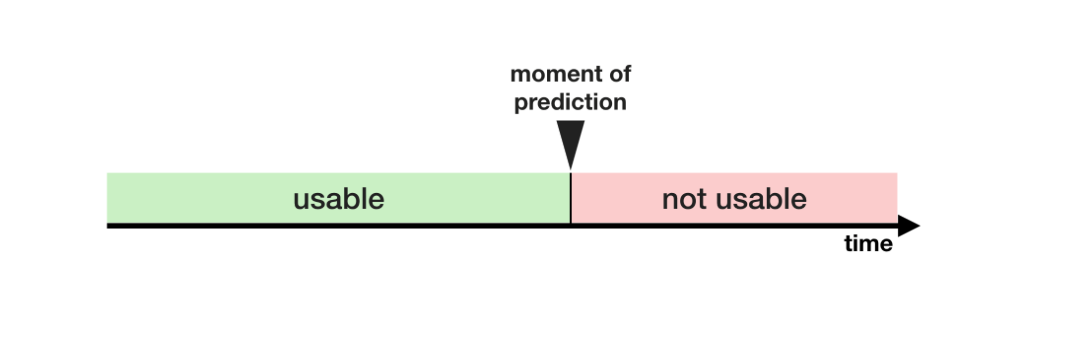

In [15]:
Image("/Users/tusharrao/Downloads/Leak.png")

### Train-Test Contamination

A different type of leak occurs when you aren't careful to distinguish training data from validation data.

Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called **train-test contamination**.

For example, imagine you run preprocessing (like fitting an imputer for missing values) before calling train_test_split(). The end result? Your model may get good validation scores, giving you great confidence in it, but perform poorly when you deploy it to make decisions.

After all, you incorporated data from the validation or test data into how you make predictions, so the may do well on that particular data even if it can't generalize to new data. This problem becomes even more subtle (and more dangerous) when you do more complex feature engineering.

If your validation is based on a simple train-test split, exclude the validation data from any type of fitting, including the fitting of preprocessing steps. This is easier if you use scikit-learn pipelines. When using cross-validation, it's even more critical that you do your preprocessing inside the pipeline!

## Example
In this example, we will learn one way to detect and remove target leakage.

We will use a dataset about credit card applications.

In [16]:
import pandas as pd

# Read the data
data = pd.read_csv('/Users/tusharrao/Downloads/AER_credit_card_data.csv', 
                   true_values = ['yes'], false_values = ['no'])

# Select target
y = data.card

# Select predictors
X = data.drop(['card'], axis=1)

print("Number of rows in the dataset:", X.shape[0])
X.head()

Number of rows in the dataset: 1319


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5


Since this is a small dataset, we will use cross-validation to ensure accurate measures of model quality.

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Since there is no preprocessing, we don't need a pipeline (used anyway as best practice!)
my_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores = cross_val_score(my_pipeline, X, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.981049


With experience, you'll find that it's very rare to find models that are accurate 98% of the time. It happens, but it's uncommon enough that we should inspect the data more closely for target leakage.

Here is a summary of the data:

- **card** : 1 if credit card application accepted, 0 if not
- **reports** : Number of major derogatory reports
- **age** : Age n years plus twelfths of a year
- **income** : Yearly income (divided by 10,000)
- **share** : Ratio of monthly credit card expenditure to yearly income
- **expenditure** : Average monthly credit card expenditure
- **owner** : 1 if owns home, 0 if rents
- **selfempl** : 1 if self-employed, 0 if not
- **dependents** : 1 + number of dependents
- **months** : Months living at current address
- **majorcards** : Number of major credit cards held
- **active** : Number of active credit accounts
  
A few variables look suspicious. For example, does expenditure mean **expenditure** on this card or on cards used before applying?

At this point, basic data comparisons can be very helpful:

In [18]:
expenditures_cardholders = X.expenditure[y]
expenditures_noncardholders = X.expenditure[~y]

print('Fraction of those who did not receive a card and had no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))
print('Fraction of those who received a card and had no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))

Fraction of those who did not receive a card and had no expenditures: 1.00
Fraction of those who received a card and had no expenditures: 0.02


As shown above, everyone who did not receive a card had no expenditures, while only 2% of those who received a card had no expenditures. It's not surprising that our model appeared to have a high accuracy. But this also seems to be a case of target leakage, where expenditures probably means expenditures on the card they applied for.

Since **share** is partially determined by **expenditure**, it should be excluded too. The variables **active** and **majorcards** are a little less clear, but from the description, they sound concerning. In most situations, it's better to be safe than sorry if you can't track down the people who created the data to find out more.

We would run a model without target leakage as follows:

In [19]:
# Drop leaky predictors from dataset
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)

# Evaluate the model with leaky predictors removed
cv_scores = cross_val_score(my_pipeline, X2, y, 
                            cv=5,
                            scoring='accuracy')

print("Cross-val accuracy: %f" % cv_scores.mean())

Cross-val accuracy: 0.833201


This accuracy is quite a bit lower, which might be disappointing. However, we can expect it to be right about 80% of the time when used on new applications, whereas the leaky model would likely do much worse than that (in spite of its higher apparent score in cross-validation).

## Conclusion
Data leakage can be multi-million dollar mistake in many data science applications. Careful separation of training and validation data can prevent train-test contamination, and pipelines can help implement this separation. Likewise, a combination of caution, common sense, and data exploration can help identify target leakage.